### Подготовительный этап

Если вкратце: хочу работать с операторами вида
\begin{align*}
\mathcal{A} \colon \mathbb{R}^{n_1 \times \ldots \times n_d} \to \mathbb{R}^{m_1 \times \ldots \times m_d}
\end{align*}

Такие операторы задаются тензорами, вида $\mathbf{A} \in
\mathbb{R}^{(m_1 \times n_1) \times \ldots \times (m_d \times n_d)}$, и TT-разложения таких
операторов содержат ядра порядка $4$. TTAX в такое не умеет, он работает только с ядрами
порядка $3$. А мне прям жесть как это нужно. В файлике я расписываю оптимальный способ получить
TT-разложение, которое мне нужно, и оптимальный способ умножить такой оператор на тензор.


In [1]:
import jax
import jax.numpy as jnp
import numpy as np
from numpy import random
import ttax
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def get_operator_from_tt(tt: ttax.base_class.TT):
    operator_cores = [
        jnp.einsum('abi,icd->abcd', tt.tt_cores[i], tt.tt_cores[i + 1])
        for i in range(0, len(tt.tt_cores), 2)
    ]
    return operator_cores

def TT_matmul(operator_cores, tt2 : ttax.base_class.TT):
    cores = [
            jnp.einsum('abic,eig->aebcg', operator_cores[i], tt2.tt_cores[i]).reshape((
                operator_cores[i].shape[0] * tt2.tt_ranks[i], operator_cores[i].shape[1],
                operator_cores[i].shape[3] * tt2.tt_ranks[i + 1]), order="F"
            )
        for i in range(len(tt2.tt_cores))
    ]
    return ttax.base_class.TT(cores)

def transpose_operator(operator_cores):
    cores = [jnp.einsum('aijb->ajib', operator_cores[i]) for i in range(len(operator_cores))]
    return cores

Простой тест: есть оператор $\mathbb{R}^{3\times2} \to \mathbb{R}^{2\times2}$, и случайный
тензор из $\mathbb{R}^{3\times2}$. Мы ожидаем, что результом применение оператора к
тензору будет тензор из $\mathbb{R}^{2\times2}$:

In [59]:
# simple test: we have an operator from R^{3x2} to R^{2x2} and random tensor from R^{3x2}
# we expect, that result of applying operator to tensor will be tensor from R^{2x2}
modes = (2, 3, 2, 2)
TT_op = ttax.random.tensor(jax.random.PRNGKey(42), modes)
TT_el = ttax.random.tensor(jax.random.PRNGKey(42), (3, 2))
print("operator shape is", TT_op.shape)
print("source tensor shape is", TT_el.shape)
print("target tensor shape is", TT_matmul(get_operator_from_tt(TT_op), TT_el).shape)

operator shape is (2, 3, 2, 2)
source tensor shape is (3, 2)
target tensor shape is (2, 2)


### Основной этап

Тестировать будем на симметричных операторах такого вида: если $\mathbf{A}$ — случайный оператор,
тогда оператор $\mathbf{A} + \mathbf{A}^T$ — симметричный.

**Проблема**: оператор для нас, это коллекция TT ядер порядка $4$, от которых ожидается только умение
каким-то образом умножаться на тензор из source пространства. Соответственно, складывать
операторы мы не умеем, поэтому не сможем сделать операцию
$(\mathbf{A} + \mathbf{A}^T)x$. Зато мы сможем сделать $(\mathbf{A}x) + (\mathbf{A}^Tx)$,
так как результатом умножения оператора на тензор является объект класса
ttax.base_class.TT. По этой причине в коде ниже будем представлять операторы, как
функции, принимающие тензор, на который надо умножить оператор.

In [45]:
make_rayleigh = lambda A: lambda x: ttax.flat_inner(x, A(x)) / ttax.flat_inner(x, x)
norm = lambda x: jnp.sqrt(ttax.flat_inner(x, x))
residual = lambda A, x, eig: norm(ttax.orthogonalize(A(x) + (-eig) * x))
retraction = lambda T: ttax.orthogonalize(ttax.round(T))

def armijo_backtracking(init, grad, mul, beta, func, x):
    alpha = init
    iters = 0
    optimal_x = retraction(x + (-alpha) * grad)
    while func(x) - func(optimal_x) < mul * alpha * norm(grad) ** 2:
        alpha *= beta
        iters += 1
        optimal_x = retraction(x + (-alpha) * grad)
        if iters > 20:
            alpha = 0.1
            optimal_x = retraction(x + (-alpha) * grad)
            break
    return optimal_x

В процессе тестирования возникала проблема: алгоритм на очередной итерации заходил в
Армихо, и больше не выходил оттуда. Чтобы избежать такой ситуации, я немного модифицировал
Армихо: если мы там находимся слишком долго, то назначим небольшую длину шага ручками и
принудительно выйдем. Если мы немного пролетели оптимальный шаг, то придётся вернуться
когда-нибудь на следующей итерации, но по крайней мере алгоритм продолжится.

In [60]:
def riemanGD(A, init, tol, max_iter = None, debug = False):
    rayleigh = make_rayleigh(A)
    rieman_grad = ttax.autodiff.grad(rayleigh)
    x = ttax.orthogonalize(init)
    residuals = [residual(A, x, rayleigh(x))]
    iters = 0
    if debug == True:
        print("№\tresidual")
    while residual(A, x, rayleigh(x)) > tol:
        rieman_x = ttax.orthogonalize(rieman_grad(x))
        x = armijo_backtracking(2, rieman_x, 1E-4, 0.8, rayleigh, x)
        iters += 1
        residuals.append(residual(A, x, rayleigh(x)))
        if debug == True:
            print("{}\t{}".format(iters, residual(A, x, rayleigh(x))))
        if (max_iter is not None and iters >= max_iter) or\
            (len(residuals) > 2 and residuals[-2] == residuals[-1]):
            break

    return x, residuals

In [64]:
core1 = np.zeros((1,4,4))
core1[0,0,0] = core1[0,2,2] = core1[0,1,1] = core1[0, 3, 3] = 1
core2 = np.zeros((4,4,4))
core2[0,0,0] = core2[1,1,1] = core2[2,2,2] = core2[3,3,3] =  1
core3 = core2.copy()
core4 = np.zeros((4,4,1))
core4[0,0,0] = core4[1,1,0] = core4[2,2,0] = core4[3,3,0] =  1
I3 = jnp.array(core2)
eye = ttax.base_class.TT(
    [core1,core2, core3, core4]
)

t = ttax.random.tensor(jax.random.PRNGKey(42),(4,4))
print("Toy test --- identity tensor")
v, rs = riemanGD(lambda x: TT_matmul(get_operator_from_tt(eye), x), t, 4E-4, 40, True)

Toy test --- identity tensor
№	residual
1	1.873849630355835
2	1.6770793199539185
3	1.4861544370651245
4	1.3066647052764893
5	1.1418572664260864
6	0.9931703209877014
7	0.8607755303382874
8	0.7440332770347595
9	0.6418342590332031
10	0.5528454184532166
11	0.4756653904914856
12	0.40892350673675537
13	0.3513321876525879
14	0.30171653628349304
15	0.25902125239372253
16	0.22231386601924896
17	0.19077332317829132
18	0.16368620097637177
19	0.1404319405555725
20	0.12047286331653595
21	0.10334417968988419
22	0.08864759653806686
23	0.07603949308395386
24	0.06522236764431
25	0.05594359710812569
26	0.047984011471271515
27	0.04115680232644081
28	0.035300806164741516
29	0.030278125777840614
30	0.02596954256296158
31	0.022273819893598557
32	0.019103819504380226
33	0.016386056318879128
34	0.01405506394803524
35	0.012054921127855778
36	0.010338861495256424
37	0.008867282420396805
38	0.007605704013258219
39	0.0065240333788096905
40	0.005595923867076635


In [65]:
print(make_rayleigh(lambda x: TT_matmul(get_operator_from_tt(eye), x))(v))
# print(ttax.full(v))

1.1145013e-06


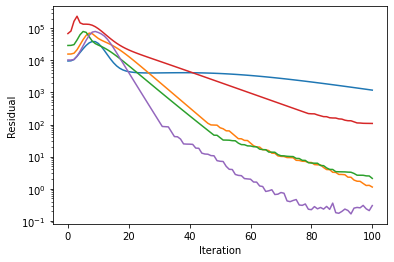

In [67]:
n = 5
graphs = []
rank = 5
for i in range(n):
    modes_op = [rank] * 8
    modes_t = [rank] * 4
    A = ttax.random.tensor(jax.random.PRNGKey(random.randint(1, 100)), modes_op)
    A_op = get_operator_from_tt(A)
    AT = transpose_operator(A_op)
    sym = lambda x: TT_matmul(A_op, x) + TT_matmul(AT, x)
    t = ttax.random.tensor(jax.random.PRNGKey(42), modes_t)
    v, rs = riemanGD(sym, t, 4E-4, 100)
    graphs.append(plt.plot(rs))

plt.xlabel("Iteration")
plt.ylabel("Residual")
plt.semilogy()
plt.show(graphs)

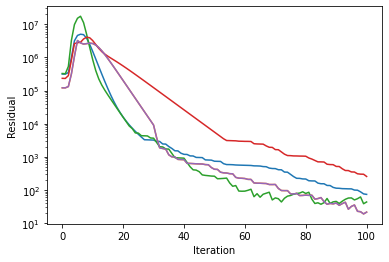

In [66]:
n = 5
graphs = []
rank = 10
for i in range(n):
    modes_op = [rank] * 8
    modes_t = [rank] * 4
    A = ttax.random.tensor(jax.random.PRNGKey(random.randint(1, 100)), modes_op)
    A_op = get_operator_from_tt(A)
    AT = transpose_operator(A_op)
    sym = lambda x: TT_matmul(A_op, x) + TT_matmul(AT, x)
    t = ttax.random.tensor(jax.random.PRNGKey(42), modes_t)
    v, rs = riemanGD(sym, t, 4E-4, 100)
    graphs.append(plt.plot(rs))
    
plt.xlabel("Iteration")
plt.ylabel("Residual")
plt.semilogy()
plt.show(graphs)

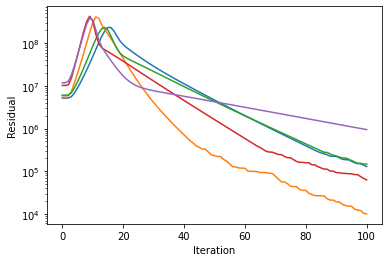

In [71]:
n = 5
graphs = []
rank = 20
for i in range(n):
    modes_op = [rank] * 8
    modes_t = [rank] * 4
    A = ttax.random.tensor(jax.random.PRNGKey(random.randint(1, 100)), modes_op)
    A_op = get_operator_from_tt(A)
    AT = transpose_operator(A_op)
    sym = lambda x: TT_matmul(A_op, x) + TT_matmul(AT, x)
    t = ttax.random.tensor(jax.random.PRNGKey(42), modes_t)
    v, rs = riemanGD(sym, t, 4E-4, 100)
    graphs.append(plt.plot(rs))

plt.xlabel("Iteration")
plt.ylabel("Residual")
plt.semilogy()
plt.show(graphs)

Чёт мне вообще такая сходимость не нравится....